In [85]:
import warnings
warnings.filterwarnings("ignore")

import os
import json
from tqdm.notebook import tqdm
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly

import sklearn
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE, Isomap

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import (KMeans, SpectralClustering, 
                             MiniBatchKMeans, AgglomerativeClustering)

from sklearn.metrics import (davies_bouldin_score, 
                            silhouette_score,
                            calinski_harabasz_score,
                            homogeneity_score)


In [86]:
!pip install arch

In [39]:
with open('config/config.json', 'r') as file:
    config = json.load(file)
    
    
rs = config['random_state']

# Loading Data

In [40]:
df = pd.read_csv(config['ticker_data_preprocessed'], index_col=0)
df_index = pd.read_csv(config['ticker_data_sp500'], index_col=0)
df_sectors = pd.read_csv(config['tickers_sectors_path'], index_col=0)
print(df.shape)
df.head()

(484, 858)


,2018-10-24,2018-10-25,2018-10-26,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-05,2018-11-06,...,2022-03-09,2022-03-10,2022-03-11,2022-03-14,2022-03-15,2022-03-16,2022-03-17,2022-03-18,2022-03-18.1,sector
A,-0.025506,0.024211,0.001917,-0.010362,0.025129,0.018070,0.006637,0.010886,-0.000303,0.001062,...,0.030467,0.008029,-0.029926,-0.020950,0.021163,0.036230,0.013482,0.016810,0.0,Healthcare
AAL,-0.063002,0.066908,0.002780,0.004313,0.063190,0.012118,0.036773,-0.001100,-0.016791,-0.015398,...,0.058475,-0.006993,-0.012676,0.016405,0.092632,0.057803,0.004857,0.012085,0.0,Industrials
AAP,-0.029213,0.025066,0.008457,0.001945,0.000607,-0.031582,0.023473,0.009113,0.000667,0.018049,...,0.021438,0.000195,-0.004099,-0.024059,0.025606,0.015910,0.003180,-0.008838,0.0,Consumer Cyclical
AAPL,-0.034302,0.021898,-0.015924,-0.018770,0.004994,0.026067,0.015352,-0.066331,-0.028388,0.010814,...,0.034997,-0.027186,-0.023909,-0.026562,0.029677,0.029015,0.006454,0.020919,0.0,Technology
ABBV,-0.042792,0.029215,-0.011501,0.007055,0.002827,-0.045839,0.030315,-0.008104,0.037959,0.013078,...,0.011485,0.002217,-0.000737,0.020395,0.024852,0.001091,0.016277,0.003846,0.0,Healthcare


In [41]:
tickers = df.index.tolist()

In [42]:
feats_tsne = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
df_tsne = pd.DataFrame({'axis0':feats_tsne[:, 0],'axis1':feats_tsne[:, 1],'sector':df['sector']})

fig = px.scatter(df_tsne, x = 'axis0', y = 'axis1', color="sector", width=800, height=600)
fig.show()

# Preprocessing

In [44]:
dict_features = dict()

## Tensors

In [45]:
from scipy.fftpack import rfft, dct
from tensorly.decomposition import parafac, tucker, parafac2
from scipy.linalg import hankel
from scipy.signal import periodogram
from arch import arch_model

SEED = 0

def hankelize(v):
    n = len(v)
    han = hankel(v[:n//2+1], v[n//2:])
    return han

#def sepctral_density(X):
#    return periodogram(X.values)[1]
#vec_sepctral_density = 

def garch(X):
    f = lambda x: arch_model(x).fit(update_freq=0, disp='off').conditional_volatility
    garch_mat = np.apply_along_axis(f, 1, X.values)
    return garch_mat
    

def construct_tensor(X, functions_to_apply = [], vec_to_matrix = None):
    N, T = X.shape
    I = 1 + len(functions_to_apply)
    tensor = [X]
    if I != 1:
        for func in functions_to_apply:
            tensor.append(func(X))
    
    tensor = np.array(tensor).reshape(I, T, N)
    if vec_to_matrix == 'hankelize':
        tensor = np.apply_along_axis(hankelize, 1, tensor)
    return np.squeeze(tensor)
    

In [46]:
X = df.drop(['sector'], axis=1)
tensor = construct_tensor(X, vec_to_matrix = "hankelize")
print(tensor.shape)
G, factors = tucker(tensor, rank=18, init='random', random_state = SEED)
A, B, C = factors
weights, (V1, V2, V3) = parafac(G, rank=18, init='random', orthogonalise=True, random_state = SEED)
dict_features['tensor;TKh;rank:18'] = C
dict_features['tensor;CPh;rank:18'] = C @ V3

(429, 429, 484)


In [47]:
funcs = [rfft, garch]
tensor = construct_tensor(X, functions_to_apply = funcs, vec_to_matrix = "hankelize")
print(tensor.shape)
G, factors = tucker(tensor, rank=18, init='random', random_state = SEED)
A, B, C, D = factors
weights, (V1, V2, V3, V4) = parafac(G, rank=18, init='random', orthogonalise=True, random_state = SEED)
dict_features['tensor;TKhf;rank:18'] = D
dict_features['tensor;CPhf;rank:18'] = D @ V4

(3, 429, 429, 484)


In [48]:
funcs = [rfft, garch]
tensor = construct_tensor(X, functions_to_apply = funcs)
G, factors = tucker(tensor, rank=18, init='random', random_state = SEED)
A, B, C = factors
print(tensor.shape)
dict_features['tensor;TKf;rank:18'] = C
weights, factors = parafac(tensor, rank=18, init='random', random_state = SEED)
A, B, C = factors
dict_features['tensor;CPf;rank:18'] = C
### CP, Tucker

(3, 857, 484)


In [49]:
X = df.drop(['sector'], axis=1)
K = 63
corr_tensor = []
for window in X.T.rolling(window=63):
    corr_tensor.append(window.corr())
tensor = np.array(corr_tensor)[K+1:]
np.array(tensor).shape

(793, 484, 484)

In [50]:
G, factors = tucker(tensor, rank=18, init='random', random_state = SEED)
A, B, C = factors
weights, (V1, V2, V3) = parafac(G, rank=18, init='random', orthogonalise=True, random_state = SEED)
dict_features['tensor;TKcor;rank:18'] = C
dict_features['tensor;CPcor;rank:18'] = C @ V3

In [51]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# y = X.T['A'].to_numpy()

# result = seasonal_decompose(y, model='additive', freq=21)

# #df['ts_mult'] = result.trend.values + result.seasonal.values

# plt.rcParams.update({'figure.figsize': (10,10)})
# result.plot().suptitle('Мультипликативная модель')
# plt.show()

## decompositions

In [52]:
# feats_pca = PCA(n_components=18, random_state=rs).fit_transform(df.drop(['sector'], axis=1))
# dict_features['decomp;pca;n_components:18'] = feats_pca

# feats_fica = FastICA(n_components=18, random_state=rs).fit_transform(df.drop(['sector'], axis=1))
# dict_features['decomp;fast_ica;n_components:18'] = feats_fica

# feats_iso = Isomap(n_components=18).fit_transform(df.drop(['sector'], axis=1))
# dict_features['decomp;isomap;n_components:18'] = feats_iso

## table data

In [53]:
table_features = pd.read_csv(config['features_path'], index_col=0)

table_features = StandardScaler().fit_transform(table_features)
dict_features['table_data;;'] = table_features

## neural network

In [54]:
# tickers = df.index.tolist()

# df_conv = pd.read_csv(config['nn_conv_data'], index_col=0).loc[tickers]
# df_mlp = pd.read_csv(config['nn_mlp_data'], index_col=0).loc[tickers]
# df_lstm = pd.read_csv(config['nn_lstm_data'], index_col=0).loc[tickers]

# dict_features['neural;conv;window:30'] = df_conv
# dict_features['neural;mlp;window:30'] = df_mlp
# dict_features['neural;lstm;window:100'] = df_lstm

## original

In [55]:
dict_features['original;;'] = df.drop(['sector'], axis=1).values

# Clustering

In [56]:
def score_func(estimator, X, y):
    labels_predicted = estimator.fit_predict(X)
    score = silhouette_score(X, labels_predicted)
    return score

def gridsearch(model, X, y, parameters:dict):
    custom_cv=[(slice(None), slice(None))]
    grid_search = GridSearchCV(model, param_grid=parameters, scoring=score_func, cv=custom_cv)
    grid_search.fit(X, y)
    labels_predicted = grid_search.best_estimator_.fit_predict(X)
    return grid_search.best_params_, labels_predicted

def parse_dict(best_params_dict, model_name, preproc_label):
    name = preproc_label + '|' + model_name + ';'
    for key, value in best_params_dict.items():
        name = name + key + ':' + str(value) + ','
    return name[:-1]
    

def train_all(models_dict, params_dict, preproc_label, X, y=None, grid_search=True, n_clusters_=config['n_clusters']):
    output = {}
    for model_name, model in models_dict.items():
        print(model_name)
        param_grid = params_dict[model_name]
        
        if grid_search:
            best_params_dict, labels_predicted = gridsearch(model, X, y, param_grid)
            final_key = parse_dict(best_params_dict, model_name, preproc_label)
        else:
            if model_name == 'Gauss_Mix': 
                model=model(n_components=n_clusters_)
            else:
                model=model(n_clusters=n_clusters_)
                
            model_loc = model.fit(X)
            labels_predicted = model_loc.labels_
            final_key = preproc_label + '|' + 'original'

        
        output[final_key] = labels_predicted
        print('done')
    return output



In [57]:
models_dict = {'Kmeans': KMeans(random_state=rs),
               'Agglomer': AgglomerativeClustering(),
               'MiniBatchKMeans': MiniBatchKMeans(random_state=rs),
               'Gauss_Mix': GaussianMixture(random_state=rs),
               'Spectral': SpectralClustering(random_state=rs)}

n_clusters = np.arange(9, 14)

params_dict = {'Kmeans': 
               {
                   'n_clusters':n_clusters,
                   'init': ['k-means++', 'random'],
                   'algorithm':['auto', 'full', 'elkan']
               },
               
               'Agglomer': 
               {
                   'n_clusters': n_clusters,
                   'linkage': ['ward', 'complete', 'average', 'single'],
               },
               'MiniBatchKMeans':
               {
                   'n_clusters': n_clusters,
                   'init':['k-means++', 'random'],
               },
               'Gauss_Mix': 
               {
                   'n_components': n_clusters,
                   'covariance_type':['full', 'tied', 'diag', 'spherical'],
                   'init_params': ['kmeans', 'random']
               },
               'Spectral': 
               {
                   'n_clusters': n_clusters,
                   'eigen_solver':['arpack', 'lobpcg'],
               }
              }

In [58]:
n_clusters_ = df_sectors['sector'].nunique()

df_predictions = pd.DataFrame(df['sector'].values, index=df.index, columns=['original'])
df_predictions['original_n'] = LabelEncoder().fit_transform(df_predictions['original'])
df_predictions.head()

,original,original_n
A,Healthcare,6
AAL,Industrials,7
AAP,Consumer Cyclical,2
AAPL,Technology,9
ABBV,Healthcare,6


In [59]:

for prepr_name, data in dict_features.items():
    print(f"--------------------- {prepr_name} ---------------------")
    X = data
    y = df['sector'].values
    gridsearch_output = train_all(models_dict, params_dict, preproc_label=prepr_name, X=X, y=y)
    prepr_predictions = pd.DataFrame(gridsearch_output, index=df_predictions.index)
    
    df_predictions = pd.concat([df_predictions, prepr_predictions], axis=1)
    print()

--------------------- tensor;TKh;rank:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- tensor;CPh;rank:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- tensor;TKhf;rank:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- tensor;CPhf;rank:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- tensor;TKf;rank:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- tensor;CPf;rank:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

--------------------- tensor;TKcor;rank:18 ---------------------
Kmeans
done
Agglomer
done
MiniBatchKMeans
done
Gauss_Mix
done
Spectral
done

----------------

In [60]:
df_predictions['original;;|original;'] = df_predictions['original_n']

In [61]:
model_name = f'original;;|random;random_state:{rs}'

X = df.drop(['sector'], axis=1).values

np.random.seed(rs)
clust_pred = np.random.choice(df_predictions['original;;|original;'].unique(), size=len(df))
df_predictions[model_name] = clust_pred

# Calculating metrics

In [62]:
def renaming(name):
    data_name, model_name = name.split('|')
    model_name = model_name[:5]
    data_name, data_surname, params = data_name.split(';')
    new_name = data_name[:4] + '_' + data_surname[:4] + '_' + model_name
    return new_name

def get_n_clusters(text):
    n_clusters = re.findall(r'(n_clusters:|n_components:)(\d+)', text)

    if len(n_clusters) == 0:
        return np.nan
    n_clusters = int(n_clusters[0][1])
    return n_clusters

In [63]:
metrics = {'silhouette':silhouette_score, 
           'davies_bouldin':davies_bouldin_score, 
           'calinski_harabasz':calinski_harabasz_score, 
           'homogeneity':homogeneity_score}


metrics_df = pd.DataFrame(columns = list(metrics.keys()))
dict_features['original;;'] = df.drop(['sector'], axis=1).values

for features_model in df_predictions.columns[2:]:
    if features_model == 'neural;lstm;window:100|Gauss_Mix;covariance_type:full,init_params:kmeans,n_components:9':
        continue
        
    features_model
    metrics_list = []
    for metric_name, metric_formula in metrics.items():
        
        if metric_name == 'homogeneity':
            metric_meaning = metric_formula(df_predictions['original'], df_predictions[features_model])
        else:
            features = features_model.split('|')[0]

            
            metric_meaning = metric_formula(dict_features[features], df_predictions[features_model])
        metrics_list.append(metric_meaning)
    metrics_df.loc[features_model] = metrics_list

    
model_params = metrics_df.index.tolist()
metrics_df.index = metrics_df.reset_index()['index'].apply(lambda x: renaming(x))
model_short_names = metrics_df.index.tolist()

In [64]:
metrics_df.columns

Index(['silhouette', 'davies_bouldin', 'calinski_harabasz', 'homogeneity'], dtype='object')

In [65]:
df_params = pd.DataFrame({'short_name': model_short_names, 
                         'all_params': model_params})
df_params['model'] = df_params['all_params'].apply(lambda x: x.split('|')[1].split(';')[0])
df_params['f_name'] = df_params['all_params'].apply(lambda x: x.split('|')[0].split(';')[0])
df_params['f_surname'] = df_params['all_params'].apply(lambda x: x.split('|')[0].split(';')[1])
df_params['f_full_name'] = df_params['f_name'] + '_' + df_params['f_surname']
df_params['n_clusters'] = df_params['all_params'].apply(lambda x: get_n_clusters(x))
df_params.head()

,short_name,all_params,model,f_name,f_surname,f_full_name,n_clusters
0,tens_TKh_Kmean,"tensor;TKh;rank:18|Kmeans;algorithm:auto,init:...",Kmeans,tensor,TKh,tensor_TKh,13.0
1,tens_TKh_Agglo,"tensor;TKh;rank:18|Agglomer;linkage:ward,n_clu...",Agglomer,tensor,TKh,tensor_TKh,9.0
2,tens_TKh_MiniB,tensor;TKh;rank:18|MiniBatchKMeans;init:k-mean...,MiniBatchKMeans,tensor,TKh,tensor_TKh,13.0
3,tens_TKh_Gauss,tensor;TKh;rank:18|Gauss_Mix;covariance_type:t...,Gauss_Mix,tensor,TKh,tensor_TKh,12.0
4,tens_TKh_Spect,tensor;TKh;rank:18|Spectral;eigen_solver:arpac...,Spectral,tensor,TKh,tensor_TKh,13.0


In [66]:
new_col_names = []
for col in df_predictions.columns:
    if len(col.split('|')) == 2:
        col = renaming(col)
    new_col_names.append(col)
    
df_predictions.columns = new_col_names
df_predictions.head()

,original,original_n,tens_TKh_Kmean,tens_TKh_Agglo,tens_TKh_MiniB,tens_TKh_Gauss,tens_TKh_Spect,tens_CPh_Kmean,tens_CPh_Agglo,tens_CPh_MiniB,...,tabl__MiniB,tabl__Gauss,tabl__Spect,orig__Kmean,orig__Agglo,orig__MiniB,orig__Gauss,orig__Spect,orig__origi,orig__rando
A,Healthcare,6,0,1,5,1,10,0,1,5,...,8,4,3,5,0,2,4,0,6,5
AAL,Industrials,7,6,6,4,3,12,6,6,4,...,1,5,9,3,0,6,6,3,7,9
AAP,Consumer Cyclical,2,10,3,8,7,1,10,3,8,...,3,1,3,4,0,8,7,10,2,1
AAPL,Technology,9,1,2,2,5,8,1,2,2,...,8,2,3,5,0,2,5,0,9,0
ABBV,Healthcare,6,7,3,9,7,1,7,3,9,...,8,4,3,1,0,8,4,10,6,3


In [67]:
def rank_methods(df):
    
    for c in df.columns:
        if c == 'davies_bouldin':
            df[c] = df[c].rank(method='dense',ascending=True).astype(int)
        else:
            df[c] = df[c].rank(method='dense',ascending=False).astype(int)
            
    return df.mean(axis=1)

def choose_method(df_mean_ranked):
    method = df_mean_ranked.argmin()
    return method


metrics_df = metrics_df.sort_values(by=['silhouette'], ascending=False)
metrics_df.head()

,silhouette,davies_bouldin,calinski_harabasz,homogeneity
index,,,,
tabl__Agglo,0.386568,0.331519,12.238592,0.015766
orig__Agglo,0.307450,0.823697,7.748862,0.035104
tabl__Spect,0.264449,0.805588,22.193927,0.045561
tens_CPco_Kmean,0.191911,1.503748,88.705101,0.424213
tabl__Kmean,0.189668,1.271666,115.045378,0.149685


In [68]:
metrics_df = metrics_df.reset_index().rename({'index':'short_name'}, axis=1)
metrics_params_df = metrics_df.merge(df_params, on='short_name')
metrics_params_df.head()

,short_name,silhouette,davies_bouldin,calinski_harabasz,homogeneity,all_params,model,f_name,f_surname,f_full_name,n_clusters
0,tabl__Agglo,0.386568,0.331519,12.238592,0.015766,"table_data;;|Agglomer;linkage:single,n_clusters:9",Agglomer,table_data,,table_data_,9.0
1,orig__Agglo,0.307450,0.823697,7.748862,0.035104,"original;;|Agglomer;linkage:average,n_clusters:9",Agglomer,original,,original_,9.0
2,tabl__Spect,0.264449,0.805588,22.193927,0.045561,"table_data;;|Spectral;eigen_solver:lobpcg,n_cl...",Spectral,table_data,,table_data_,11.0
3,tens_CPco_Kmean,0.191911,1.503748,88.705101,0.424213,"tensor;CPcor;rank:18|Kmeans;algorithm:auto,ini...",Kmeans,tensor,CPcor,tensor_CPcor,12.0
4,tabl__Kmean,0.189668,1.271666,115.045378,0.149685,"table_data;;|Kmeans;algorithm:auto,init:random...",Kmeans,table_data,,table_data_,9.0


In [69]:
mean_rnk_cl_data = dict()
pd_best_clust_model = pd.DataFrame()
best_methods = []

for preproc in df_params['f_full_name'].unique():
    
    metrics_params_df_loc = metrics_params_df[(metrics_params_df['f_full_name'] == preproc)&
                                         (metrics_params_df['short_name'] != 'orig__rando')&
                                         (metrics_params_df['short_name'] != 'orig__origi')]
    
    metrics_rank = metrics_params_df_loc[['silhouette', 'davies_bouldin', 'calinski_harabasz','homogeneity']]
    df_mean_ranked = rank_methods(metrics_rank.copy())
    rank_dict = dict(zip(metrics_params_df_loc['short_name'].values.tolist() , df_mean_ranked.values.tolist()))
    mean_rnk_cl_data.update(rank_dict)
    
    best_method = metrics_params_df_loc['short_name'].iloc[np.argmin(df_mean_ranked)]

    
    best_methods.append(best_method)
    
mean_rnk_cl_data['orig__rando'] = np.nan
mean_rnk_cl_data['orig__origi'] = np.nan

In [70]:
metrics_params_df['mean_rnk_cl_data'] = metrics_params_df['short_name'].map(mean_rnk_cl_data)
metrics_params_df.head()

,short_name,silhouette,davies_bouldin,calinski_harabasz,homogeneity,all_params,model,f_name,f_surname,f_full_name,n_clusters,mean_rnk_cl_data
0,tabl__Agglo,0.386568,0.331519,12.238592,0.015766,"table_data;;|Agglomer;linkage:single,n_clusters:9",Agglomer,table_data,,table_data_,9.0,3.0
1,orig__Agglo,0.307450,0.823697,7.748862,0.035104,"original;;|Agglomer;linkage:average,n_clusters:9",Agglomer,original,,original_,9.0,3.0
2,tabl__Spect,0.264449,0.805588,22.193927,0.045561,"table_data;;|Spectral;eigen_solver:lobpcg,n_cl...",Spectral,table_data,,table_data_,11.0,3.0
3,tens_CPco_Kmean,0.191911,1.503748,88.705101,0.424213,"tensor;CPcor;rank:18|Kmeans;algorithm:auto,ini...",Kmeans,tensor,CPcor,tensor_CPcor,12.0,1.5
4,tabl__Kmean,0.189668,1.271666,115.045378,0.149685,"table_data;;|Kmeans;algorithm:auto,init:random...",Kmeans,table_data,,table_data_,9.0,2.0


In [71]:
metrics_best = metrics_params_df.query('short_name in @best_methods')
metrics_best

,short_name,silhouette,davies_bouldin,calinski_harabasz,homogeneity,all_params,model,f_name,f_surname,f_full_name,n_clusters,mean_rnk_cl_data
3,tens_CPco_Kmean,0.191911,1.503748,88.705101,0.424213,"tensor;CPcor;rank:18|Kmeans;algorithm:auto,ini...",Kmeans,tensor,CPcor,tensor_CPcor,12.0,1.50
4,tabl__Kmean,0.189668,1.271666,115.045378,0.149685,"table_data;;|Kmeans;algorithm:auto,init:random...",Kmeans,table_data,,table_data_,9.0,2.00
6,tens_CPf_Kmean,0.178228,1.432833,230.964275,0.038416,"tensor;CPf;rank:18|Kmeans;algorithm:auto,init:...",Kmeans,tensor,CPf,tensor_CPf,9.0,1.75
15,tens_CPhf_Kmean,0.134917,1.726405,49.172982,0.067708,"tensor;CPhf;rank:18|Kmeans;algorithm:auto,init...",Kmeans,tensor,CPhf,tensor_CPhf,12.0,1.25
19,tens_TKco_Kmean,0.108840,2.090268,21.202794,0.500571,"tensor;TKcor;rank:18|Kmeans;algorithm:auto,ini...",Kmeans,tensor,TKcor,tensor_TKcor,13.0,1.50
20,tens_TKf_Kmean,0.106348,2.421986,15.580728,0.068684,"tensor;TKf;rank:18|Kmeans;algorithm:auto,init:...",Kmeans,tensor,TKf,tensor_TKf,13.0,1.00
31,orig__MiniB,0.065281,2.466249,20.273643,0.283521,"original;;|MiniBatchKMeans;init:random,n_clust...",MiniBatchKMeans,original,,original_,10.0,2.25
32,tens_TKhf_Gauss,0.060807,2.578820,13.082008,0.058427,tensor;TKhf;rank:18|Gauss_Mix;covariance_type:...,Gauss_Mix,tensor,TKhf,tensor_TKhf,13.0,2.00
36,tens_TKh_Kmean,0.048315,2.635543,12.188206,0.068871,"tensor;TKh;rank:18|Kmeans;algorithm:auto,init:...",Kmeans,tensor,TKh,tensor_TKh,13.0,1.00
37,tens_CPh_Kmean,0.048315,2.635543,12.188206,0.068871,"tensor;CPh;rank:18|Kmeans;algorithm:auto,init:...",Kmeans,tensor,CPh,tensor_CPh,13.0,1.00


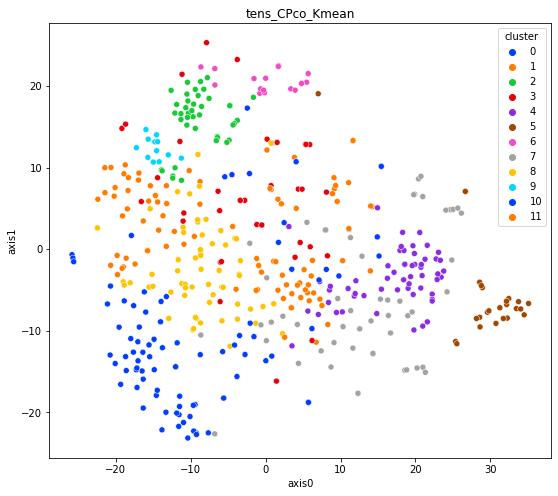

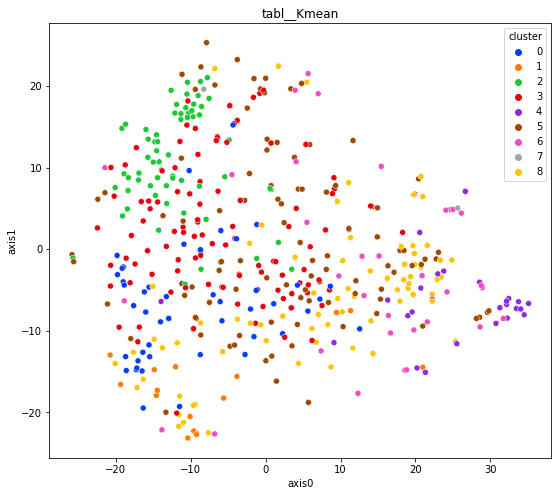

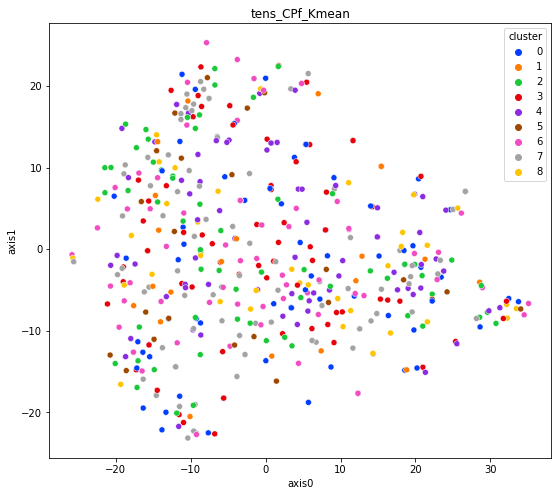

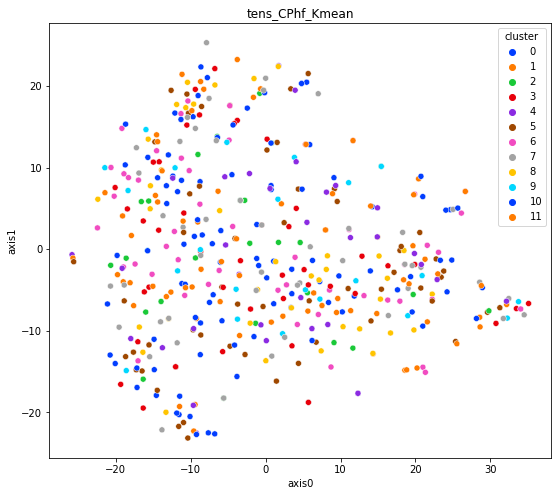

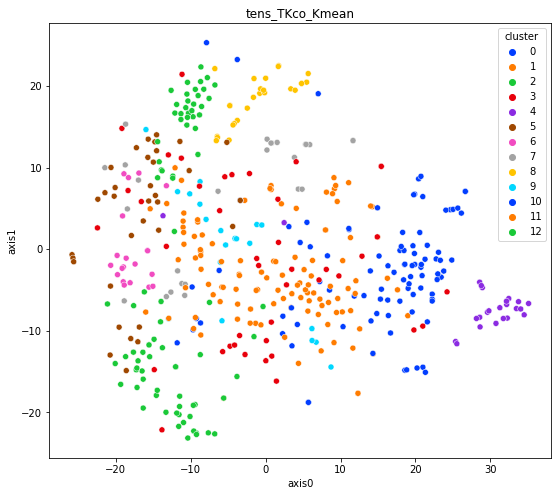

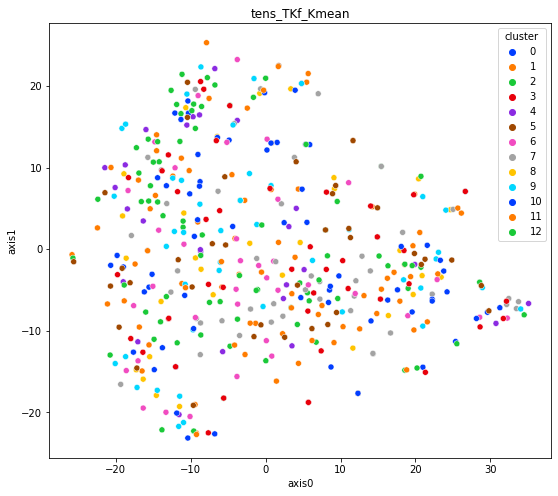

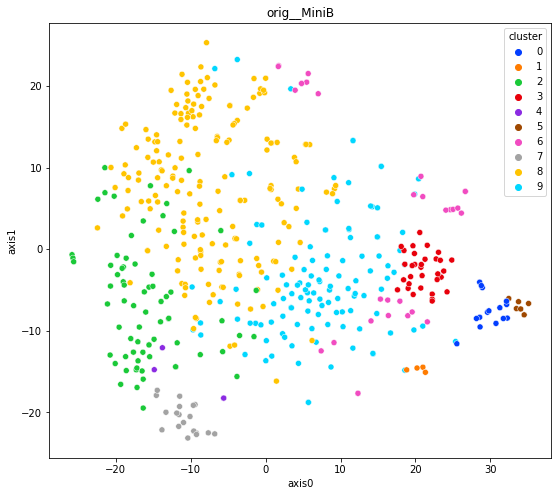

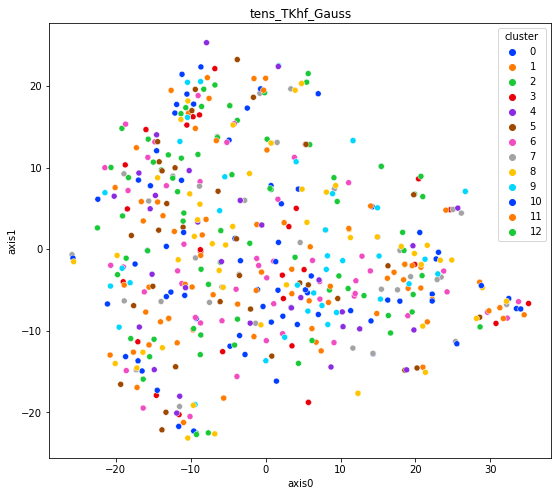

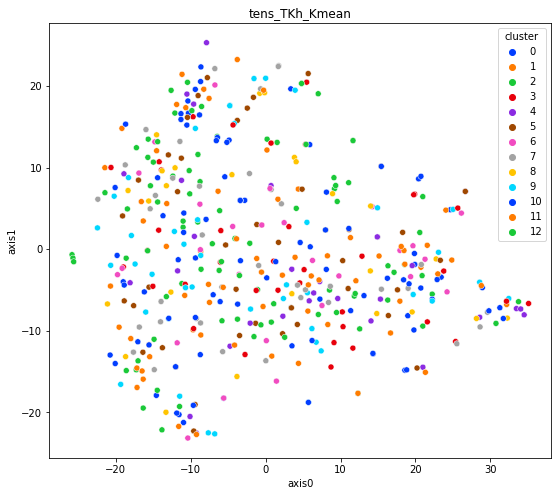

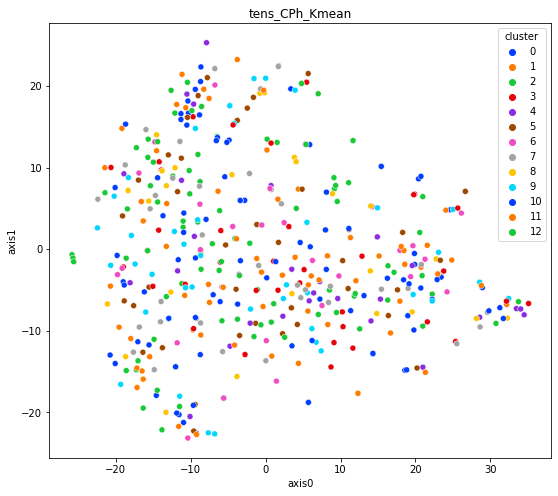

In [72]:
feats_tsne = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
for method in metrics_best['short_name']:
    
    clusters = df_predictions[method]
    df_tsne = pd.DataFrame({'axis0':feats_tsne[:, 0],'axis1':feats_tsne[:, 1],'cluster':clusters})
    plt.figure(figsize=(9, 8))
    sns.scatterplot(x=df_tsne['axis0'], y=df_tsne['axis1'], hue=df_tsne['cluster'], palette='bright')
    plt.title(method)
    plt.show()

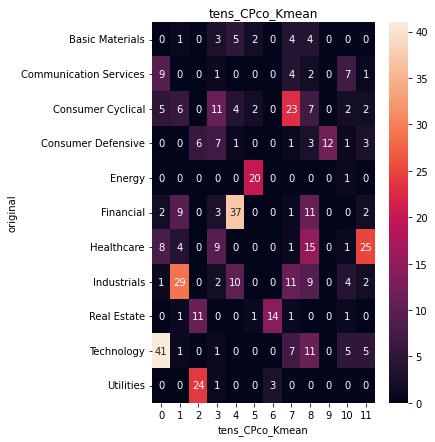

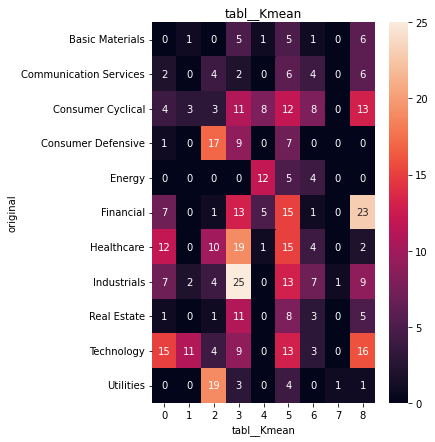

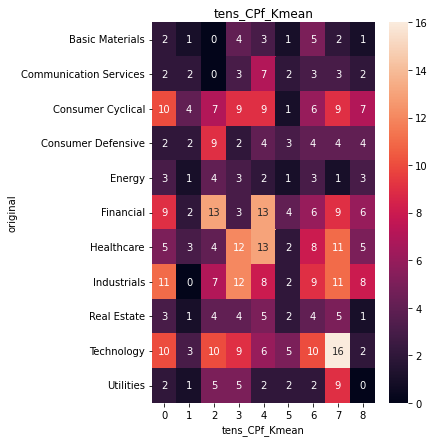

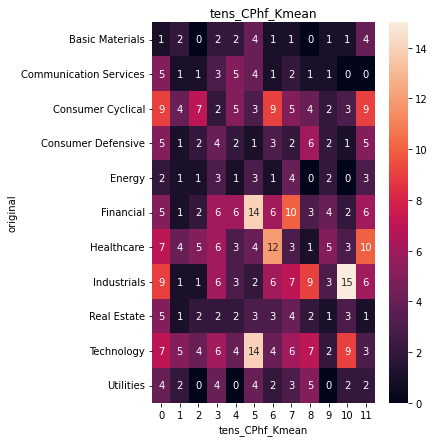

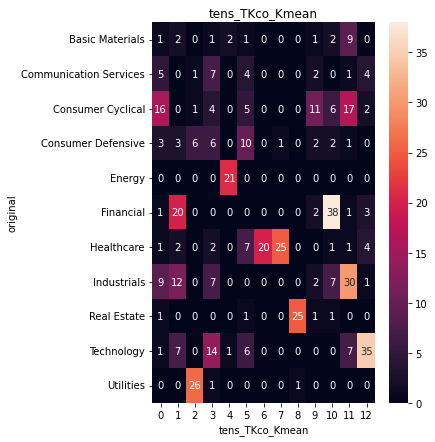

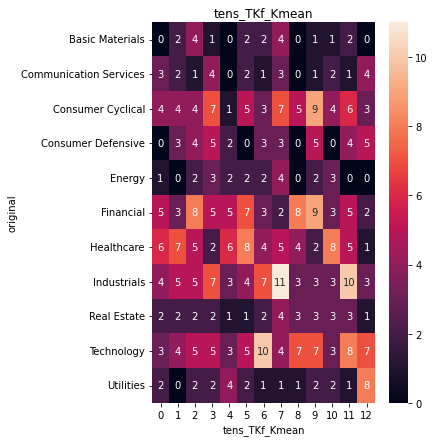

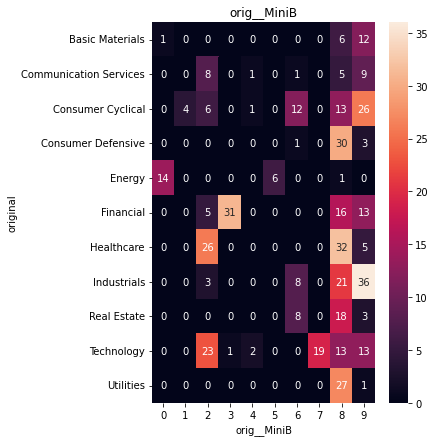

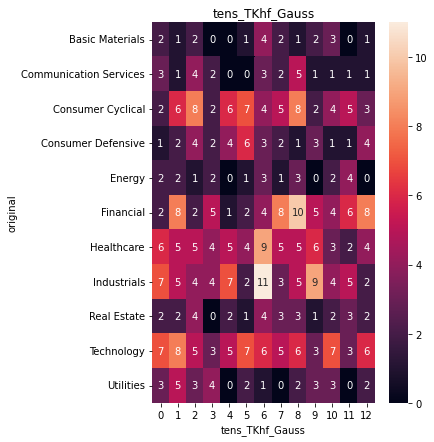

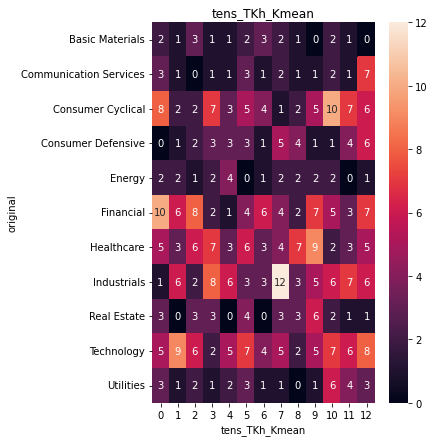

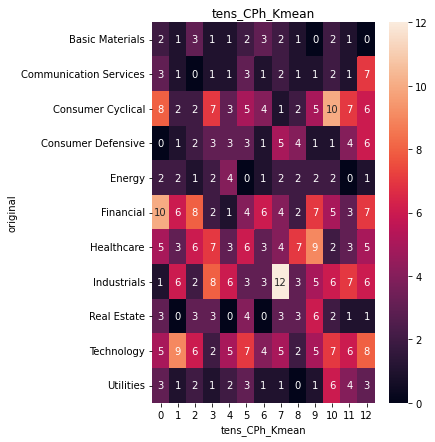

In [73]:
for method in metrics_best['short_name']:
    
    df_crosstab = pd.crosstab(df_predictions['original'], df_predictions[method])
    plt.figure(figsize=(5, 7))
    sns.heatmap(df_crosstab, annot=True)
    plt.title(method)
    plt.show()

# Saving results

In [74]:
metrics_df.to_csv(config['metrics_path'])
df_predictions.to_csv(config['predictions_path'])
df_params.to_csv(config['params_path'])
metrics_best.drop(['all_params'], axis=1).to_csv(config['best_metrics_path'])